## Translational embeddings (TransE)

### Parameters
Define hyper-parameters inclduing the evaluation information:

This is the basic set of parameters for a TransE model
 
Unless you have a powerful GPU or use a different dataset than the one provided, set the number of epochs to a low number (5 or 10) for this tutorial; when you want to use and apply the model for a prediction task later, train for more epochs (ideally, on a good GPU).

In [1]:
org_id = '9606' # 4932 - yeast, 9606 - human

embeddings_size = 50
batch_size = 32
margin = 0.1
reg_norm = 1
optimizer = 'adam'
loss_function = 'mse'
epochs = 100


In [2]:
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, CSVLogger
import numpy as np
import pandas as pd
from rdflib import Graph
import math
import os


class TransE(tf.keras.Model):
    
    def __init__(self, nb_classes, nb_relations, embedding_size, margin=0.1, reg_norm=1):
        super(TransE, self).__init__()
        self.nb_classes = nb_classes
        self.nb_relations = nb_relations
        self.margin = margin
        self.reg_norm = 1
        bound = 6 / math.sqrt(embedding_size)
        cls_weights = np.random.uniform(low=-bound, high=bound, size=(nb_classes, embedding_size))
        rel_weights = np.random.uniform(low=-bound, high=bound, size=(nb_relations, embedding_size))
        self.cls_embeddings = tf.keras.layers.Embedding(
            nb_classes,
            embedding_size,
            input_length=1,
            weights=[cls_weights,])
        self.rel_embeddings = tf.keras.layers.Embedding(
            nb_relations,
            embedding_size,
            input_length=1,
            weights=[rel_weights,])
    
    def reg(self, x):
        res = tf.abs(tf.norm(x, axis=1) - self.reg_norm)
        res = tf.reshape(res, [-1, 1])
        return res
    
        
    def call(self, input):
        pos, neg = input
        ph, pl, pt = pos[:, 0], pos[:, 1], pos[:, 2]
        nh, nl, nt = neg[:, 0], neg[:, 1], neg[:, 2]
        nh = self.cls_embeddings(nh)
        nl = self.rel_embeddings(nl)
        nt = self.cls_embeddings(nt)
        ph = self.cls_embeddings(ph)
        pl = self.rel_embeddings(pl)
        pt = self.cls_embeddings(pt)
        
        pos = tf.subtract(tf.add(ph, pl), pt)
        neg = tf.subtract(tf.add(nh, nl), nt)
        
        self._loss = tf.norm(pos, axis=1) - tf.norm(neg, axis=1) + self.margin
        self._loss = tf.reduce_sum(tf.nn.relu(self._loss))
        self._loss = (tf.reshape(self._loss, [-1, 1]) + self.reg(ph)
                      + self.reg(ph) + self.reg(nh) + self.reg(nh))
        return self._loss

    
class Generator(object):

    def __init__(self, data, triple_set, nb_classes, batch_size):
        self.data = data
        self.triple_set = triple_set
        self.nb_classes = nb_classes
        self.size = len(data)
        self.start = 0
        self.batch_size = batch_size

    def __iter__(self):
        return self

    def __next__(self):
        if self.start < self.size:
            end = self.start + self.batch_size
            batch = self.data[self.start:end]
            neg_triples = []
            for h, l, t in batch:
                while True:
                    hn = h
                    tn = t
                    if np.random.choice([False, True]):
                        hn = np.random.randint(0, self.nb_classes)
                    else:
                        tn = np.random.randint(0, self.nb_classes)
                    if (hn, l, tn) not in self.triple_set:
                        neg_triples.append((hn, l, tn))
                        break
            self.start = end
            batch = np.hstack(batch).reshape(len(batch), 3)
            neg_triples = np.hstack(neg_triples).reshape(len(neg_triples), 3)
            labels = np.zeros((len(batch), 1), dtype='float32')
            return ([batch, neg_triples], labels)
        else:
            self.start = 0
            return self.__next__()
            #raise StopIteration()


def load_data(filename=f'data/train/{org_id}.plain.nt', format='nt'):
    g = Graph()
    g.parse(filename, format=format)
    classes = {}
    relations = {}
    data = []
    for h, l, t in g:
        h, l, t = str(h), str(l), str(t)
        if h not in classes:
            classes[h] = len(classes)
        if t not in classes:
            classes[t] = len(classes)
        if l not in relations:
            relations[l] = len(relations)
        data.append((classes[h], relations[l], classes[t]))
    return data, classes, relations

def load_valid_data(data_file, classes, relations):
    data = []
    rel = f'http://interacts'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((classes[id1], relations[rel], classes[id2]))
    return data

data, classes, relations = load_data()
train_steps = int(math.ceil(len(data) / batch_size))
train_generator = Generator(data, set(data), len(classes), batch_size)

valid_data = load_valid_data(f'data/valid/{org_id}.protein.links.v11.0.txt', classes, relations)
valid_generator = Generator(valid_data, set(data), len(classes), batch_size)
valid_steps = int(math.ceil(len(valid_data) / batch_size))

pos_input = Input(shape=(3,), dtype='int32')
neg_input = Input(shape=(3,), dtype='int32')
transe_model = TransE(len(classes), len(relations), embeddings_size)
out = transe_model([pos_input, neg_input])
model = tf.keras.Model(inputs=[pos_input, neg_input], outputs=out)
model.compile(optimizer=optimizer, loss=loss_function)

model.fit_generator(
    train_generator,
    steps_per_epoch=train_steps,
    epochs=epochs,
    validation_data=valid_generator,
    validation_steps=valid_steps,
    workers=4,
)


/home/kulmanm/KAUST/CBRC/ontology-tutorial/venv/lib/python3.6/site-packages/tensorflow/python/ops/gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Epoch 1/100
26023/26023 [==============================] - 291s 11ms/step - loss: 114.0954 - val_loss: 18.6479
Epoch 2/100
26023/26023 [==============================] - 265s 10ms/step - loss: 21.8254 - val_loss: 4.5449
Epoch 3/100
26023/26023 [==============================] - 257s 10ms/step - loss: 5.7751 - val_loss: 1.1735
Epoch 4/100
26023/26023 [==============================] - 249s 10ms/step - loss: 1.5106 - val_loss: 0.4180
Epoch 5/100
26023/26023 [==============================] - 246s 9ms/step - loss: 0.7002 - val_loss: 0.2671
Epoch 6/100
26023/26023 [==============================] - 241s 9ms/step - loss: 0.5357 - val_loss: 0.2256
Epoch 7/100
26023/26023 [==============================] - 243s 9ms/step - loss: 0.3710 - val_loss: 0.2029
Epoch 8/100
26023/26023 [==============================] - 244s 9ms/step - loss: 0.2403 - val_loss: 0.1865
Epoch 9/100
26023/26023 [==============================] - 246s 9ms/step - loss: 0.2016 - val_loss: 0.1826
Epoch 10/100
26023/26023 [===

Epoch 77/100
26023/26023 [==============================] - 238s 9ms/step - loss: 0.0661 - val_loss: 0.1110
Epoch 78/100
26023/26023 [==============================] - 238s 9ms/step - loss: 0.0671 - val_loss: 0.1129
Epoch 79/100
26023/26023 [==============================] - 238s 9ms/step - loss: 0.0663 - val_loss: 0.1056
Epoch 80/100
26023/26023 [==============================] - 238s 9ms/step - loss: 0.0658 - val_loss: 0.1070
Epoch 81/100
26023/26023 [==============================] - 238s 9ms/step - loss: 0.0662 - val_loss: 0.1098
Epoch 82/100
26023/26023 [==============================] - 237s 9ms/step - loss: 0.0656 - val_loss: 0.1081
Epoch 83/100
26023/26023 [==============================] - 237s 9ms/step - loss: 0.0663 - val_loss: 0.1077
Epoch 84/100
26023/26023 [==============================] - 237s 9ms/step - loss: 0.0657 - val_loss: 0.1054
Epoch 85/100
26023/26023 [==============================] - 237s 9ms/step - loss: 0.0648 - val_loss: 0.1060
Epoch 86/100
26023/26023 [==

### Save embeddings:

The embeddings provided in the data package have been trained for 100 epochs and may provide better results; you may want to skip this step.

In [3]:
cls_embeddings = transe_model.cls_embeddings.get_weights()[0]
rel_embeddings = transe_model.rel_embeddings.get_weights()[0]
cls_embeddings = list(cls_embeddings)
rel_embeddings = list(rel_embeddings)

if not os.path.exists('data/transe'):
    os.makedirs('data/transe')

df = pd.DataFrame({'classes': list(classes.keys()), 'embeddings': cls_embeddings})
df.to_pickle(f'data/transe/{org_id}_cls_embeddings.pkl')

df = pd.DataFrame({'relations': list(relations.keys()), 'embeddings': rel_embeddings})
df.to_pickle(f'data/transe/{org_id}_rel_embeddings.pkl')

### Evaluation results on test set:
 * Hits@k, k $\in$ {10, 100}
 * Mean rank
 * ROC AUC

In [6]:
from scipy.stats import rankdata
org_id = '4932'

def load_test_data(data_file, classes, relations):
    data = []
    rel = f'http://interacts'
    with open(data_file, 'r') as f:
        for line in f:
            it = line.strip().split()
            id1 = f'http://{it[0]}'
            id2 = f'http://{it[1]}'
            if id1 not in classes or id2 not in classes or rel not in relations:
                continue
            data.append((id1, rel, id2))
    return data

def compute_rank_roc(ranks, n_prots):
    auc_x = list(ranks.keys())
    auc_x.sort()
    auc_y = []
    tpr = 0
    sum_rank = sum(ranks.values())
    for x in auc_x:
        tpr += ranks[x]
        auc_y.append(tpr / sum_rank)
    auc_x.append(n_prots)
    auc_y.append(1)
    auc = np.trapz(auc_y, auc_x) / n_prots
    return auc

# Load embeddings from saved files
cls_df = pd.read_pickle(f'data/transe/{org_id}_cls_embeddings.pkl')
rel_df = pd.read_pickle(f'data/transe/{org_id}_rel_embeddings.pkl')
classes = {v: k for k, v in enumerate(cls_df['classes'])}
relations = {v: k for k, v in enumerate(rel_df['relations'])}

nb_classes = len(cls_df)
nb_relations = len(rel_df)
embeds_list = cls_df['embeddings'].values
rembeds_list = rel_df['embeddings'].values
size = len(embeds_list[0])
embeds = np.zeros((nb_classes, size), dtype=np.float32)
for i, emb in enumerate(embeds_list):
    embeds[i, :] = emb

proteins = {}
for k, v in classes.items():
    if not k.startswith('http://GO:'):
        proteins[k] = v

print('Proteins: ', len(proteins))

prot_index = list(proteins.values())
prot_embeds = embeds[prot_index, :]
prot_dict = {v: k for k, v in enumerate(prot_index)}
    
rsize = len(rembeds_list[0])
rembeds = np.zeros((nb_relations, rsize), dtype=np.float32)
for i, emb in enumerate(rembeds_list):
    rembeds[i, :] = emb

# Load training data to computed filtered rank
train_data = load_test_data(f'data/train/{org_id}.protein.links.v11.0.txt', classes, relations)
valid_data = load_test_data(f'data/valid/{org_id}.protein.links.v11.0.txt', classes, relations)
trlabels = {}
for c, r, d in train_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000
for c, r, d in valid_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in trlabels:
        trlabels[r] = np.ones((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    trlabels[r][c, d] = 1000


# Load test data and compute ranks for each protein
test_data = load_test_data(f'data/test/{org_id}.protein.links.v11.0.txt', classes, relations)
top1 = 0
top10 = 0
top100 = 0
mean_rank = 0
ftop1 = 0
ftop10 = 0
ftop100 = 0
fmean_rank = 0
labels = {}
preds = {}
ranks = {}
franks = {}
eval_data = test_data
n = len(eval_data)
for c, r, d in eval_data:
    c, r, d = prot_dict[classes[c]], relations[r], prot_dict[classes[d]]
    if r not in labels:
        labels[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.int32)
    if r not in preds:
        preds[r] = np.zeros((len(prot_embeds), len(prot_embeds)), dtype=np.float32)
    labels[r][c, d] = 1
    ec = prot_embeds[c, :]
    er = rembeds[r, :]
    ec += er

    # Compute distance
    dst = np.linalg.norm(prot_embeds - ec.reshape(1, -1), axis=1)
    res = dst.flatten()

    preds[r][c, :] = res
    index = rankdata(res, method='average')
    rank = index[d]
    if rank == 1:
        top1 += 1
    if rank <= 10:
        top10 += 1
    if rank <= 100:
        top100 += 1
    mean_rank += rank
    if rank not in ranks:
        ranks[rank] = 0
    ranks[rank] += 1

    # Filtered rank
    index = rankdata((res * trlabels[r][c, :]), method='average')
    rank = index[d]
    if rank == 1:
        ftop1 += 1
    if rank <= 10:
        ftop10 += 1
    if rank <= 100:
        ftop100 += 1
    fmean_rank += rank

    if rank not in franks:
        franks[rank] = 0
    franks[rank] += 1
top1 /= n
top10 /= n
top100 /= n
mean_rank /= n
ftop1 /= n
ftop10 /= n
ftop100 /= n
fmean_rank /= n

rank_auc = compute_rank_roc(ranks, len(proteins))
frank_auc = compute_rank_roc(franks, len(proteins))

print(f'{top10:.2f} {top100:.2f} {mean_rank:.2f} {rank_auc:.2f}')
print(f'{ftop10:.2f} {ftop100:.2f} {fmean_rank:.2f} {frank_auc:.2f}')

Proteins:  6229
0.06 0.32 1125.44 0.82
0.13 0.40 1074.69 0.83


### Visualize embeddings

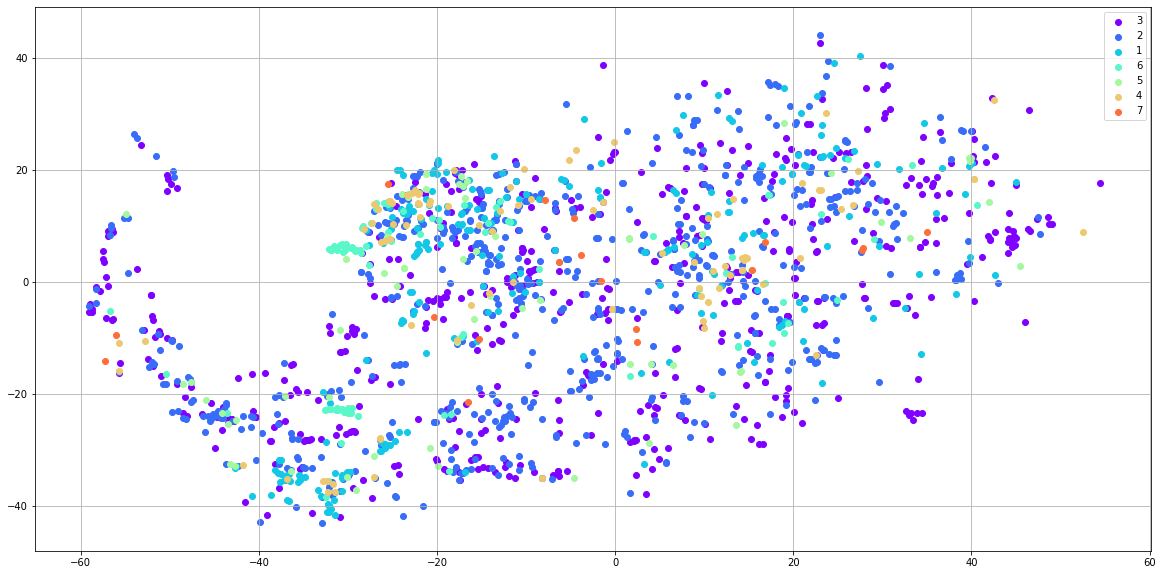

In [7]:
from matplotlib import pyplot as plt
from MulticoreTSNE import MulticoreTSNE as TSNE
X = TSNE(n_components=2, verbose=1, n_iter=2500, n_jobs=8).fit_transform(prot_embeds)

ec_numbers = {}
with open('data/yeast_ec.tab') as f:
    next(f)
    for line in f:
        it = line.strip().split('\t', -1)
        if len(it) < 5:
            continue
        if it[3]:
            prot_id = it[3].split(';')[0]
            prot_id = 'http://{0}'.format(prot_id)    
            ec_numbers[prot_id] = it[4]
ec_classes = {'0': [[], []]}
for i, item in enumerate(proteins.items()):
    k, v = item
    if k in ec_numbers:
        ec = ec_numbers[k].split('.')[0]
        if ec not in ec_classes:
            ec_classes[ec] = [[], []]
        ec_classes[ec][0].append(X[i, 0])
        ec_classes[ec][1].append(X[i, 1])
colors = iter(plt.cm.rainbow(np.linspace(0, 1, len(ec_classes))))
fig, ax = plt.subplots(figsize=(20, 10))

for ec, items in ec_classes.items():
    if ec == '0':
        continue
    color = next(colors)
    ax.scatter(items[0], items[1], color=color, label=ec)

ax.legend()
ax.grid(True)

plt.show()

### Task 2: Infer top 10 functions for a query protein

In [ ]:
query = 'http://4932.YOR234C'